In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import glob
from librosa.util import sync
from librosa.onset import onset_strength
from librosa.beat import beat_track
import deepdish as dd
import os
import scipy
from audioutils import *

# Algorithms for Chroma-Based Shingles

In [2]:
def btchroma_to_fftmat(btchroma, win):
    """
    Stack the flattened result of fft2 on patches 12 x win
    -> python: TBM, 2011-11-05, TESTED
    """
    # 12 semitones
    nchrm, nbeats = btchroma.shape
    assert nchrm == 12, 'beat-aligned matrix transposed?'
    if nbeats < win:
        return None
    # output
    fftmat = np.zeros((nchrm * win, nbeats - win + 1))
    for i in range(nbeats-win+1):
        F = scipy.fftpack.fft2(btchroma[:,i:i+win])
        F = np.sqrt(np.real(F)**2 + np.imag(F)**2)
        patch = scipy.fftpack.fftshift(F)
        fftmat[:, i] = patch.flatten()
    return fftmat

def get_ftm2d_shingles(chroma, pwr=1.96, block_size=75, C=5):
    """
    Compute median Fourier 2D magnitude shingles
    https://academiccommons.columbia.edu/doi/10.7916/D8TH8WXJ/download

    Parameters
    ----------
    chroma: ndarray(12, n_frames)
        Chroma matrix
    pwr: float
        Power to which to raise chroma for compression
    block_size: int
        Block size for each chroma shingle
    C: float
        Normalization factor for log
    
    Returns
    -------
    ndarray(12*block_size)
        The normalized median shingle
    """
    from audioutils import chrompwr
    shingle = np.zeros(12*block_size)
    if chroma.shape[1] > block_size:
        chroma = chrompwr(chroma, pwr)    
        # Get all 2D FFT magnitude shingles
        shingles = btchroma_to_fftmat(chroma, block_size).T
        Norm = np.sqrt(np.sum(shingles**2, 1))
        Norm[Norm == 0] = 1
        shingles = np.log(C*shingles/Norm[:, None] + 1)
        shingle = np.median(shingles, 0) # Median aggregate
        shingle = shingle/np.sqrt(np.sum(shingle**2))
    else:
        print("WARNING: Not enough beats for shingle; {} beats, block size {}".format(chroma.shape[1], block_size))
    return shingle


def crema(y, sr, hop_length=512):
    """
    Compute "convolutional and recurrent estimators for music analysis" (CREMA)
    and resample so that it's reported in hop_length intervals
    NOTE: This code is a bit finnecky, and is recommended for Python 3.5
    Returns
    -------
    crema: ndarray(n_frames, 12)
        The crema coefficients at each frame
    """
    import crema
    from scipy import interpolate
    model = crema.models.chord.ChordModel()
    data = model.outputs(y=y, sr=sr)
    fac = (float(sr)/44100.0)*4096.0/hop_length
    times_orig = fac*np.arange(len(data['chord_bass']))
    nwins = int(np.floor(float(y.size) / hop_length))
    times_new = np.arange(nwins)
    interp = interpolate.interp1d(times_orig, data['chord_pitch'].T, kind='nearest', fill_value='extrapolate')
    return interp(times_new)

# Step 1: Compute Shingles for all query tunes

In [3]:
hop_length = 512
SUPERFLUX_SIZE = 5
sr = 44100

tunes = []
for f in sorted(glob.glob("Tunes/*.mp3")):
    y, sr = librosa.load(f, sr=sr)
    f = f.split("Tunes/")[1]
    idx = f.index("_")
    name = f[0:idx]
    f = f[idx+1::]
    idx = f.index("_")
    version = f[0:idx]
    url = "https://www.youtube.com/watch?v={}".format(f[idx+1:-4])
    # Save off metadata
    tune = dict(name=name, version=version, url=url)
    print(name, version, url)
    
    oenv = onset_strength(y=y, sr=sr, hop_length=hop_length, max_size=SUPERFLUX_SIZE)
    _, beats = beat_track(onset_envelope=oenv, sr=sr, hop_length=hop_length)
    beats = np.array(np.round(beats), dtype=int)
    beats[beats >= oenv.size] = oenv.size-1
    C = crema(y, sr, hop_length)
    C = sync(C, beats, aggregate=np.median)
    tune["shingle"] = get_ftm2d_shingles(C)
    tunes.append(tune)

Let It Be 80s Metal Ballad Cover https://www.youtube.com/watch?v=05UPiDZPrQY


2023-10-26 15:15:13.232191: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-26 15:15:13.319033: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-26 15:15:13.321598: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-26 15:15:13.321610: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

1/1 [==============================] - 1s 1s/step
Let It Be Andrés Macnamara https://www.youtube.com/watch?v=VMRcZzScaPw
1/1 [==============================] - 1s 1s/step
Let It Be Billy Joel (with Paul McCartney) https://www.youtube.com/watch?v=GXxmukqA2Zo
1/1 [==============================] - 1s 1s/step
Let It Be J-Min 제이민 https://www.youtube.com/watch?v=yUy2VJrIDcs
1/1 [==============================] - 1s 905ms/step
Let It Be JP Cooper https://www.youtube.com/watch?v=mjZjumldZ0A
1/1 [==============================] - 1s 1s/step
Let It Be Matt Hylom acoustic cover https://www.youtube.com/watch?v=v7wErmth4k4
1/1 [==============================] - 1s 1s/step
Let It Be The Beatles (Original) https://www.youtube.com/watch?v=QfB09CeGpAU
1/1 [==============================] - 1s 977ms/step
Let It Be Vazquez Sounds https://www.youtube.com/watch?v=LTG-uVV_6q0
1/1 [==============================] - 1s 1s/step
MJBad (Piano Cover) - Peter Bence https://www.youtube.com/watch?v=0H4rq0L9OSw
1/1 

# Step 2: Compute shingles for all Datacos database tunes

In [4]:
if not os.path.exists("datacos_shingles.h5"):
    X = []
    for i, f in enumerate(glob.glob("acoss/features_benchmark/*.h5")):
        if i%100 == 0:
            print(".", end="", flush=True)
        res = dd.io.load(f)
        C = sync(res['crema'].T, res['madmom_features']['onsets'], aggregate=np.median)
        X.append(get_ftm2d_shingles(C))
    dd.io.save("datacos_shingles.h5", {"X":np.array(X)})
X = dd.io.load("datacos_shingles.h5")["X"]

(15000, 900)
(32, 900)


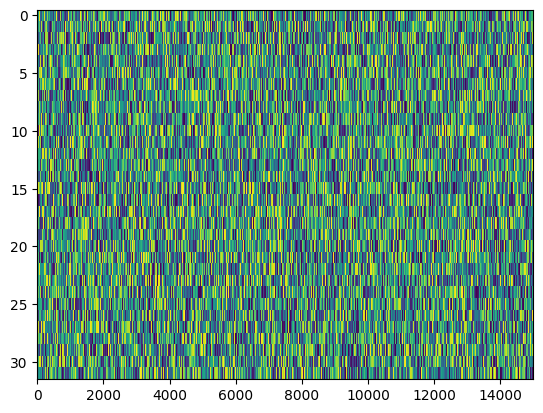

In [5]:
def get_csm(X, Y, do_sqrt=True):
    """
    Return the Euclidean cross-similarity matrix between the M points
    in the Mxd matrix X and the N points in the Nxd matrix Y.
    :param X: An Mxd matrix holding the coordinates of M points
    :param Y: An Nxd matrix holding the coordinates of N points
    :return D: An MxN Euclidean cross-similarity matrix
    """
    C = np.sum(X**2, 1)[:, None] + np.sum(Y**2, 1)[None, :] - 2*X.dot(Y.T)
    C[C < 0] = 0
    if do_sqrt:
        C = np.sqrt(C)
    return C

XD = np.array(X)
print(XD.shape)

XQ = np.array([tune["shingle"] for tune in tunes])
print(XQ.shape)

D = get_csm(XQ, XD)
idx = np.argsort(D, axis=1)
plt.imshow(idx, aspect='auto', interpolation='none')

for i, t in enumerate(tunes):
    del t["shingle"]
    t["rankings"] = idx[i, :].tolist()
    
import json
json.dump(tunes, open("tunes.json", "w"))

In [6]:
from ranking import *
N = XQ.shape[0]
D = np.zeros((N, N))
for i in range(N):
    print(".", end="")
    for j in range(i+1, N):
        D[i, j] = kendall_tau(idx[i, :], idx[j, :])
D = D + D.T

................................

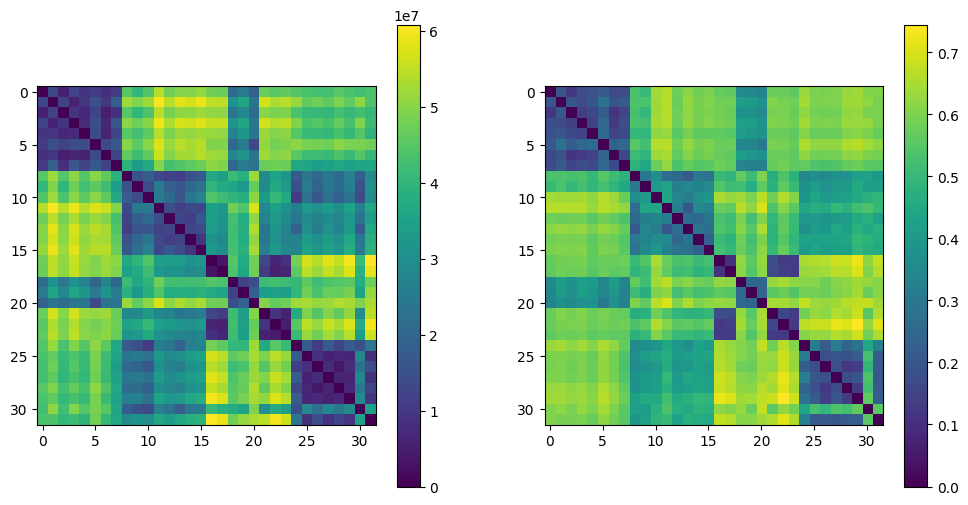

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(D)
plt.colorbar()
plt.subplot(122)
plt.imshow(get_csm(XQ, XQ))
plt.colorbar()

In [8]:
for i, t in enumerate(tunes):
    print(i, t["name"], t["version"])

0 Let It Be 80s Metal Ballad Cover
1 Let It Be Andrés Macnamara
2 Let It Be Billy Joel (with Paul McCartney)
3 Let It Be J-Min 제이민
4 Let It Be JP Cooper
5 Let It Be Matt Hylom acoustic cover
6 Let It Be The Beatles (Original)
7 Let It Be Vazquez Sounds
8 MJBad (Piano Cover) - Peter Bence
9 MJBad Billie Elish
10 MJBad Celine Dion @ Incognito tournée, 1988
11 MJBad Glee Cast Version
12 MJBad Original by Michael Jackson
13 MJBad Weird Al' Yankovic - Fat
14 MJBad guitar cover
15 MJBad metal cover by Leo Moracchioli
16 Shake It Off ATC Cover
17 Shake It Off Cover by Twenty One Two
18 Shake It Off Metal cover by Leo Moracchioli
19 Shake It Off Ryan Adams 
20 Shake It Off Screaming Females
21 Shake It Off Taylor Swift (Official)
22 Shake It Off Tiffany Alvord Acoustic Cover
23 Shake It Off Walk off the Earth
24 Smells Like Teen Spirit Bass cover by 10 years old
25 Smells Like Teen Spirit Cover by Halocene
26 Smells Like Teen Spirit Electric Guitar Cover by Kfir Ochaion
27 Smells Like Teen Spi

/home/ctralie/anaconda3/envs/mir/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
/home/ctralie/anaconda3/envs/mir/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
/home/ctralie/anaconda3/envs/mir/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from current font.
/home/ctralie/anaconda3/envs/mir/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ctralie/anaconda3/envs/mir/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ctralie/anaconda3/envs/mir/lib/python3.7/site-packages/IPython/core/pylabtools.

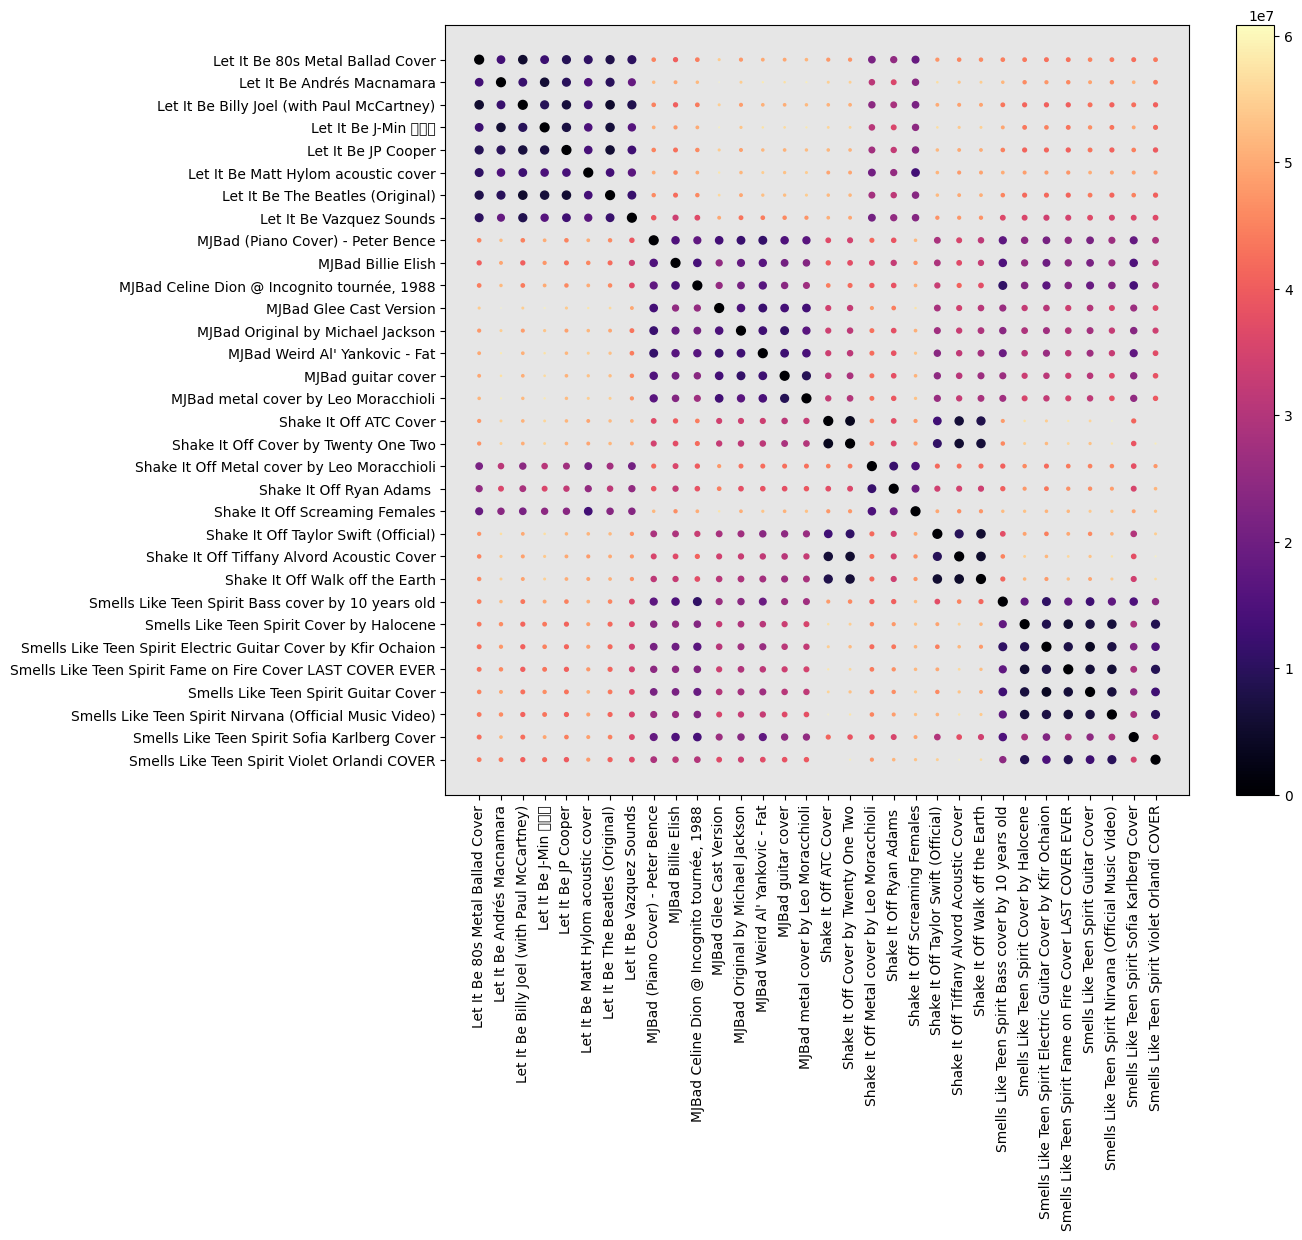

In [9]:
N = XQ.shape[0]

plt.savefig("CoverResults.svg", bbox_inches='tight')

In [12]:
import json
tunes = json.load(open("tunes.json", encoding="utf8"))
tunes[0]

{'name': 'Let It Be',
 'version': '80s Metal Ballad Cover',
 'url': 'https://www.youtube.com/watch?v=05UPiDZPrQY',
 'ratings': [1915,
  13527,
  5851,
  9665,
  10371,
  14086,
  7903,
  5727,
  5355,
  9058,
  10617,
  5094,
  14733,
  12056,
  13538,
  7088,
  12072,
  8470,
  9678,
  13268,
  2946,
  10334,
  4795,
  14608,
  2458,
  9211,
  10878,
  6183,
  13055,
  7685,
  2825,
  12807,
  12705,
  8755,
  983,
  10363,
  1945,
  2814,
  12124,
  1538,
  12066,
  2823,
  11113,
  7787,
  14422,
  8216,
  8806,
  10731,
  3521,
  8397,
  7252,
  7848,
  10967,
  3794,
  4365,
  2284,
  3836,
  2144,
  10147,
  8413,
  1932,
  2942,
  3721,
  4187,
  5297,
  1181,
  8400,
  6452,
  14648,
  11985,
  11283,
  345,
  6336,
  11158,
  6258,
  14435,
  7434,
  2451,
  11659,
  6139,
  224,
  13707,
  14830,
  1710,
  726,
  10312,
  12802,
  2078,
  8396,
  12158,
  7502,
  13587,
  11299,
  6001,
  13435,
  6748,
  13042,
  9009,
  11880,
  4564,
  10146,
  12599,
  14762,
  5533,
  63